In [5]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))


2.6.2
1:  []


In [6]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import tabloo
from tensorflow import keras
# from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error
from ipywidgets import interactive
%matplotlib inline

## Data Processing

### Data Fetching and Cleaning

In [7]:
#getting data and sorting it into all the present IDs

scaler = MinMaxScaler()
df_normal = pd.read_csv('train_1.csv', delimiter=',')
df_normal = df_normal.dropna(axis=1, how='all')
df_normal[['Time']] = scaler.fit_transform(df_normal[['Time']])

# all_IDs = np.array(df_normal.groupby(['ID']).count().index.values)
# print((np.sort(all_IDs)))
all_IDs = np.array(['id1','id5'])
print(all_IDs)
df_ID_list = list()
for i in all_IDs:
    temp = df_normal[df_normal['ID']==i].dropna(axis=1, how='all')
    temp = temp.drop(temp[['Label']],axis =1)
    temp = temp.drop(temp[['ID']],axis =1)
    temp = temp.iloc[0:1000000,0:2]
    df_ID_list.append(temp)

for i in range(len(df_ID_list)):
    # tabloo.show(i)
    print(len(df_ID_list[i]))
    print(df_ID_list[i])

['id1' 'id5']
1000000
                 Time   Signal1
5        7.768963e-07  0.000000
12       1.743012e-06  0.000000
20       2.709128e-06  0.000000
27       3.675243e-06  0.000000
33       4.641359e-06  0.000000
...               ...       ...
7166892  9.662234e-01  0.797424
7166902  9.662244e-01  0.797524
7166907  9.662253e-01  0.797604
7166915  9.662263e-01  0.797704
7166922  9.662273e-01  0.797794

[1000000 rows x 2 columns]
1000000
                 Time   Signal1
0        0.000000e+00  0.000000
6        9.661157e-07  0.000000
13       1.932231e-06  0.000000
21       2.898347e-06  0.000000
28       3.864463e-06  0.000000
...               ...       ...
7166897  9.662238e-01  0.226013
7166905  9.662248e-01  0.225260
7166912  9.662257e-01  0.224512
7166918  9.662267e-01  0.223505
7166927  9.662276e-01  0.222048

[1000000 rows x 2 columns]


In [8]:
df_ID_list[1]['Signal1']

0          0.000000
6          0.000000
13         0.000000
21         0.000000
28         0.000000
             ...   
7166897    0.226013
7166905    0.225260
7166912    0.224512
7166918    0.223505
7166927    0.222048
Name: Signal1, Length: 1000000, dtype: float64

['id1' 'id5']
250000
         Label          Time  Signal1_of_ID
1            0  5.674957e-08       0.165060
7            0  3.389731e-06       0.165400
16           0  6.722713e-06       0.165821
22           0  1.005570e-05       0.166301
29           0  1.338868e-05       0.166662
...        ...           ...            ...
1791696      0  8.333274e-01       0.409938
1791705      0  8.333307e-01       0.409137
1791711      0  8.333341e-01       0.408346
1791718      0  8.333374e-01       0.407586
1791726      0  8.333407e-01       0.406815

[250000 rows x 3 columns]
250000
         Label      Time  Signal1_of_ID
4            0  0.000001       0.037628
12           0  0.000005       0.037723
19           0  0.000008       0.037833
27           0  0.000011       0.037915
32           0  0.000015       0.037969
...        ...       ...            ...
1791700      0  0.833328       0.093077
1791708      0  0.833332       0.092897
1791713      0  0.833335       0.092724
1791723      0  0

Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

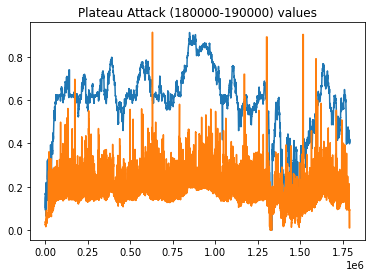

In [9]:
df_test_plat_ID1 = pd.read_csv('test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1.dropna(axis=1, how='all')
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
# df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:400000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

all__test_IDs = np.array(['id1','id5'])
print(all_IDs)
df_testID_list = list()

for i in all__test_IDs:
    tempTest = df_test_plat_ID1[df_test_plat_ID1['ID']==i].dropna(axis=1, how='all')
    # tempTest = tempTest.drop(tempTest[['Label']],axis =1)
    tempTest = tempTest.drop(tempTest[['ID']],axis =1)
    tempTest = tempTest.iloc[0:250000,0:3]
    df_testID_list.append(tempTest)

for i in range(len(df_testID_list)):
    # tabloo.show(i)
    print(len(df_testID_list[i]))
    print(df_testID_list[i])


plt.plot(df_testID_list[0].iloc[:,2:3])
plt.plot(df_testID_list[1].iloc[:,2:3])
plt.title('Plateau Attack (180000-190000) values')

In [10]:


# create a test dataset of 30 sequences from the provided Data
def createTestDataset(x,y,time_step):
    Xs,Ys = [],[]
    for j in range(len(x)):
        v = []
        p = []
        for i in range(len(x[j])-time_step):
            y = x[j]['Signal1_of_ID'].iloc[i:i+time_step].values
            v.append(y)
            p.append(x[j]['Signal1_of_ID'].iloc[i+time_step])
        Xs.append(v)
        Ys.append(p)
    
    # print(Xs)
    # print(Ys)
            
    return np.array(Xs),np.array(Ys)
    

In [11]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs,Ys = [],[]
    for j in range(len(x)):
        v = []
        p = []
        for i in range(len(x[j])-time_step):
            y = x[j]['Signal1'].iloc[i:i+time_step].values
            v.append(y)
            p.append(x[j]['Signal1'].iloc[i+time_step])
        Xs.append(v)
        Ys.append(p)
    
    # print(Xs)
    # print(Ys)
            
    return np.array(Xs),np.array(Ys)
    

In [12]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_ID_list, df_ID_list, TIME_STEP)
X_test, Y_test = createTestDataset(df_testID_list, df_testID_list, TIME_STEP)

# X_train.shape

# X_test.shape

In [13]:
print(X_train.shape)
print(Y_train.shape)

(2, 999970, 30)
(2, 999970)


In [14]:
print(X_test.shape)
print(Y_test.shape)

(2, 249970, 30)
(2, 249970)


In [15]:
a = np.reshape(X_train,(-1,2,30,1))
b = np.reshape(Y_train,(-1,2,1))

print(a.shape)
print(b.shape)

(999970, 2, 30, 1)
(999970, 2, 1)


In [16]:
p = np.reshape(X_test,(-1,2,30,1))
q = np.reshape(Y_test,(-1,2,1))
print(p.shape)
print(q.shape)

(249970, 2, 30, 1)
(249970, 2, 1)


In [17]:
print(a.shape)
print(a)

(999970, 2, 30, 1)
[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 ...


 [[[0.21071127]
   [0.21224839]
   [0.21353995]
   ...
   [0.22860827]
   [0.22812398]
   [0.22744244]]

  [[0.21224839]
   [0.21353995]
   [0.21457229]
   ...
   [0.22812398]
   [0.22744244]
   [0.2267609 ]]]


 [[[0.21353995]
   [0.21457229]
   [0.21503333]
   ...
   [0.22744244]
   [0.2267609 ]
   [0.22601284]]

  [[0.21457229]
   [0

In [ ]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(
    TimeDistributed(
        LSTM(128, activation='relu', return_sequences = True), 
        input_shape=(2,30,1) #all IDs LSTMs 
    )
)

model.add(
    TimeDistributed(
        Flatten() 
    )
)
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(TimeDistributed(Dense(30)))
model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()
# plot_model(model, to_file='model_plot.png', 
#            show_shapes=True, show_layer_names=True,
#            show_layer_activations=False, expand_nested=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 2, 30, 128)        66560     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 3840)           0         
_________________________________________________________________
dense (Dense)                (None, 2, 512)            1966592   
_________________________________________________________________
dense_1 (Dense)              (None, 2, 64)             32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2, 256)            16640     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 2, 30)             7710      
Total params: 2,090,334
Trainable params: 2,090,334
Non-trainable params: 0
______________________________________________

In [15]:
# fit model
model.fit(a, b, epochs=15, batch_size=30, validation_split=0.1, shuffle=False)
model.save("multi_ID_LSTM_autoenc")

Epoch 1/15
30000/30000 [==============================] - 450s 15ms/step - loss: 0.0123 - val_loss: 0.0276
Epoch 2/15
30000/30000 [==============================] - 455s 15ms/step - loss: 0.0129 - val_loss: 0.0107
Epoch 3/15
30000/30000 [==============================] - 456s 15ms/step - loss: 0.0130 - val_loss: 0.0046
Epoch 4/15
30000/30000 [==============================] - 452s 15ms/step - loss: 0.0135 - val_loss: 0.0061
Epoch 5/15
30000/30000 [==============================] - 448s 15ms/step - loss: 0.0125 - val_loss: 0.0072
Epoch 6/15
30000/30000 [==============================] - 447s 15ms/step - loss: 0.0129 - val_loss: 0.0136
Epoch 7/15
30000/30000 [==============================] - 447s 15ms/step - loss: 0.0101 - val_loss: 0.0080
Epoch 8/15
30000/30000 [==============================] - 447s 15ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 9/15
30000/30000 [==============================] - 447s 15ms/step - loss: 0.0076 - val_loss: 0.0034
Epoch 10/15
30000/30000 [============

Above model took 1.875 Hours to train

#### With ELU Activation

In [41]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(
    TimeDistributed(
        LSTM(128, activation='elu', return_sequences = True), 
        input_shape=(2,30,1) #all IDs LSTMs 
    )
)

model.add(
    TimeDistributed(
        Flatten() 
    )
)
model.add(Dense(512, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(256, activation='elu'))

model.add(TimeDistributed(Dense(30)))
model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()
# plot_model(model, to_file='model_plot.png', 
#            show_shapes=True, show_layer_names=True,
#            show_layer_activations=False, expand_nested=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 2, 30, 128)        66560     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 3840)           0         
_________________________________________________________________
dense (Dense)                (None, 2, 512)            1966592   
_________________________________________________________________
dense_1 (Dense)              (None, 2, 64)             32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2, 256)            16640     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 2, 30)             7710      
Total params: 2,090,334
Trainable params: 2,090,334
Non-trainable params: 0
______________________________________________

In [42]:
# fit model
model.fit(a, b, epochs=15, batch_size=30, validation_split=0.1, shuffle=False)
model.save("multi_ID_LSTM_autoenc_elu")

Epoch 1/15
30000/30000 [==============================] - 469s 16ms/step - loss: 0.0118 - val_loss: 0.0198
Epoch 2/15
30000/30000 [==============================] - 472s 16ms/step - loss: 0.0078 - val_loss: 0.0058
Epoch 3/15
30000/30000 [==============================] - 467s 16ms/step - loss: 0.0088 - val_loss: 0.0096
Epoch 4/15
30000/30000 [==============================] - 468s 16ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 5/15
30000/30000 [==============================] - 467s 16ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 6/15
30000/30000 [==============================] - 467s 16ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 7/15
30000/30000 [==============================] - 467s 16ms/step - loss: 0.0054 - val_loss: 0.0079
Epoch 8/15
30000/30000 [==============================] - 467s 16ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 9/15
30000/30000 [==============================] - 476s 16ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 10/15
30000/30000 [============

#### Model Fitting

#### Model Prediction

In [18]:
reconstructed_model = keras.models.load_model("multi_ID_LSTM_autoenc_elu")

In [19]:
x_test_predict = reconstructed_model.predict(p, verbose=0)
x_train_predict = reconstructed_model.predict(a, verbose=0)

print(x_train_predict.shape)
print(x_test_predict.shape)

(999970, 2, 30)
(249970, 2, 30)


In [20]:
x_test_predict_X= x_test_predict[:,0]
print(x_test_predict[:,0])
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
print(p[:,0])
print("\n------------------------------------------------------------------------------------------------------------------\n")
print(x_test_predict[:,1])
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
print(p[:,1])

[[0.17683482 0.17527986 0.17787588 ... 0.17807847 0.17894769 0.17756855]
 [0.17638212 0.17482442 0.17742157 ... 0.17762727 0.17849845 0.17711705]
 [0.17610466 0.17454416 0.17712915 ... 0.17734635 0.17820609 0.17682618]
 ...
 [0.11132103 0.10941315 0.1112473  ... 0.11244708 0.11260551 0.11097473]
 [0.10574216 0.103917   0.10690939 ... 0.10728103 0.10851914 0.10664088]
 [0.10238051 0.10060215 0.10435653 ... 0.10420012 0.10616416 0.10410547]]
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
[[[0.16505995]
  [0.16540026]
  [0.1658207 ]
  ...
  [0.168033  ]
  [0.16778276]
  [0.16760261]]

 [[0.1658207 ]
  [0.16630121]
  [0.16666157]
  ...
  [0.16760261]
  [0.16741244]
  [0.1672623 ]]

 [[0.16666157]
  [0.16690179]
  [0.16701191]
  ...
  [0.1672623 ]
  [0.16715218]
  [0.16702208]]

 ...

 [[0.00916778]
  [0.00916778]
  [0.00916778]
  ...
  [0.09382376]
  [0.09363249]
  [0.09344575]]

 [[0.00916778]
  [0.00916778]
  [0.00916778]
  ...
  [0.09344575

#### Prediction reshaping

In [21]:
x_train_predict_res_1 = np.reshape(x_train_predict[:,0],(-1,30,1))
x_train_predict_res_2 = np.reshape(x_train_predict[:,1],(-1,30,1))
x_test_predict_res_1 = np.reshape(x_test_predict[:,0],(-1,30,1))
x_test_predict_res_2 = np.reshape(x_test_predict[:,1],(-1,30,1))

print(x_train_predict_res_1.shape)
print(x_train_predict_res_2.shape)
print(x_test_predict_res_1.shape)
print(x_test_predict_res_2.shape)

(999970, 30, 1)
(999970, 30, 1)
(249970, 30, 1)
(249970, 30, 1)


#### Loss Calculation

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

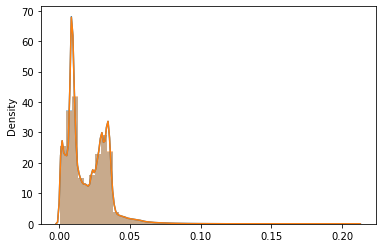

In [22]:
# Seperate test loss calculation
train_mae_loss_1 = np.mean(np.abs(x_train_predict_res_1 - a[:,0]), axis=1)
train_mae_loss_2 = np.mean(np.abs(x_train_predict_res_2 - a[:,1]), axis=1)
sns.distplot(train_mae_loss_1,bins=50,kde=True )
sns.distplot(train_mae_loss_2,bins=50,kde=True )

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

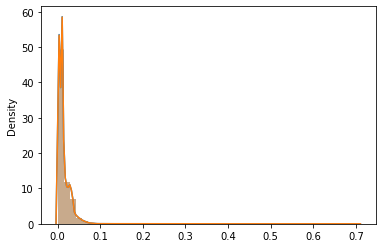

In [23]:
# Seperate test loss calculation
test_mae_loss_1 = np.mean(np.abs(x_test_predict_res_1 - p[:,0]), axis=1)
test_mae_loss_2 = np.mean(np.abs(x_test_predict_res_2 - p[:,1]), axis=1)
sns.distplot(test_mae_loss_1,bins=50,kde=True )
sns.distplot(test_mae_loss_2,bins=50,kde=True )

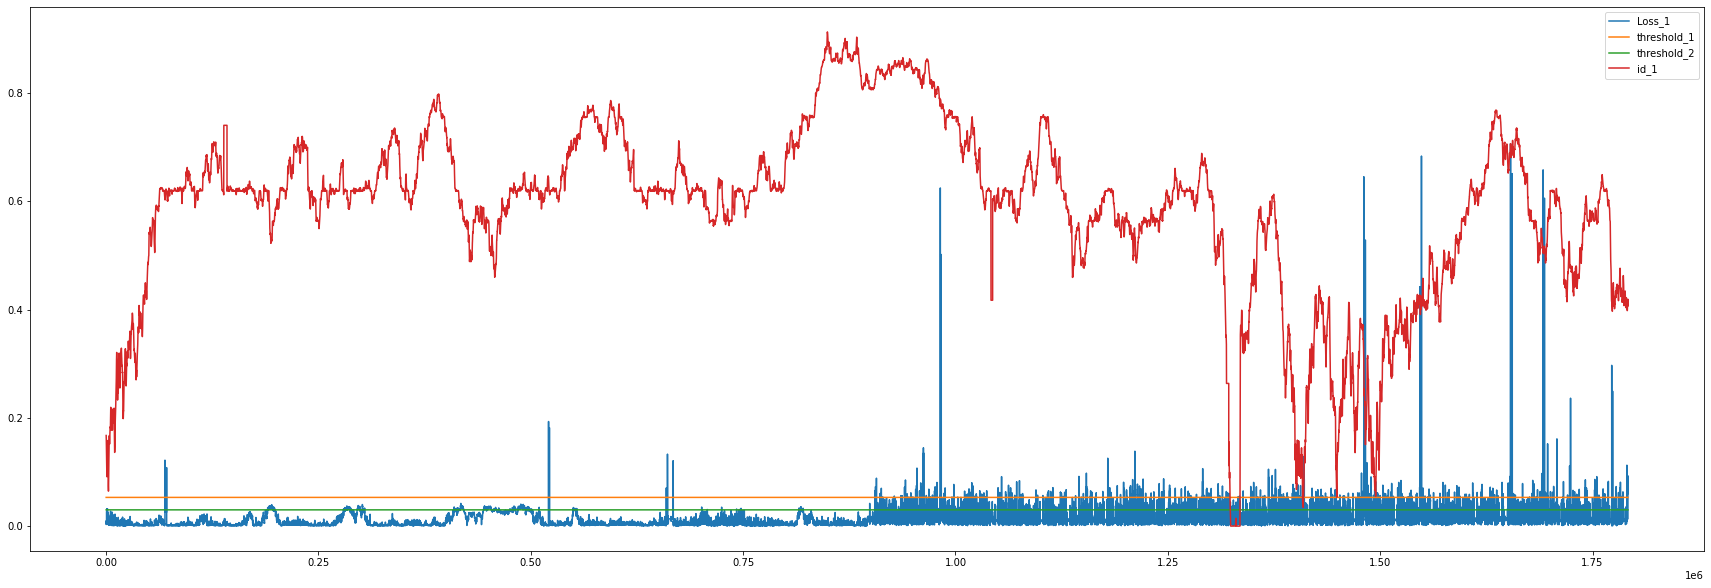

In [24]:
# #plot the threshoold vs the actual loss values
test_score_df = pd.DataFrame(index=df_testID_list[0][TIME_STEP:].index)
test_score_df['id_1'] = df_testID_list[0][TIME_STEP:].Signal1_of_ID
test_score_df['Label'] = df_testID_list[0][TIME_STEP:].Label
test_score_df['loss'] = test_mae_loss_1
test_score_df['threshold_1'] = 0.053
test_score_df['threshold_2'] = 0.03
test_score_df['anomaly_1'] = test_score_df.loss > test_score_df.threshold_1
test_score_df['anomaly_2'] = test_score_df.loss > test_score_df.threshold_2


plt.figure(figsize=(30,10))
plt.plot(test_score_df.index,test_score_df.loss, label='Loss_1')
plt.plot(test_score_df.index,test_score_df.threshold_1, label='threshold_1')
plt.plot(test_score_df.index,test_score_df.threshold_2, label='threshold_2')
plt.plot(test_score_df.index,test_score_df.id_1, label='id_1')
plt.legend()

In [25]:

print(df_testID_list[0][TIME_STEP:].head())

     Label      Time  Signal1_of_ID
215      0  0.000100       0.167412
221      0  0.000103       0.167262
230      0  0.000107       0.167152
236      0  0.000110       0.167022
243      0  0.000113       0.166892


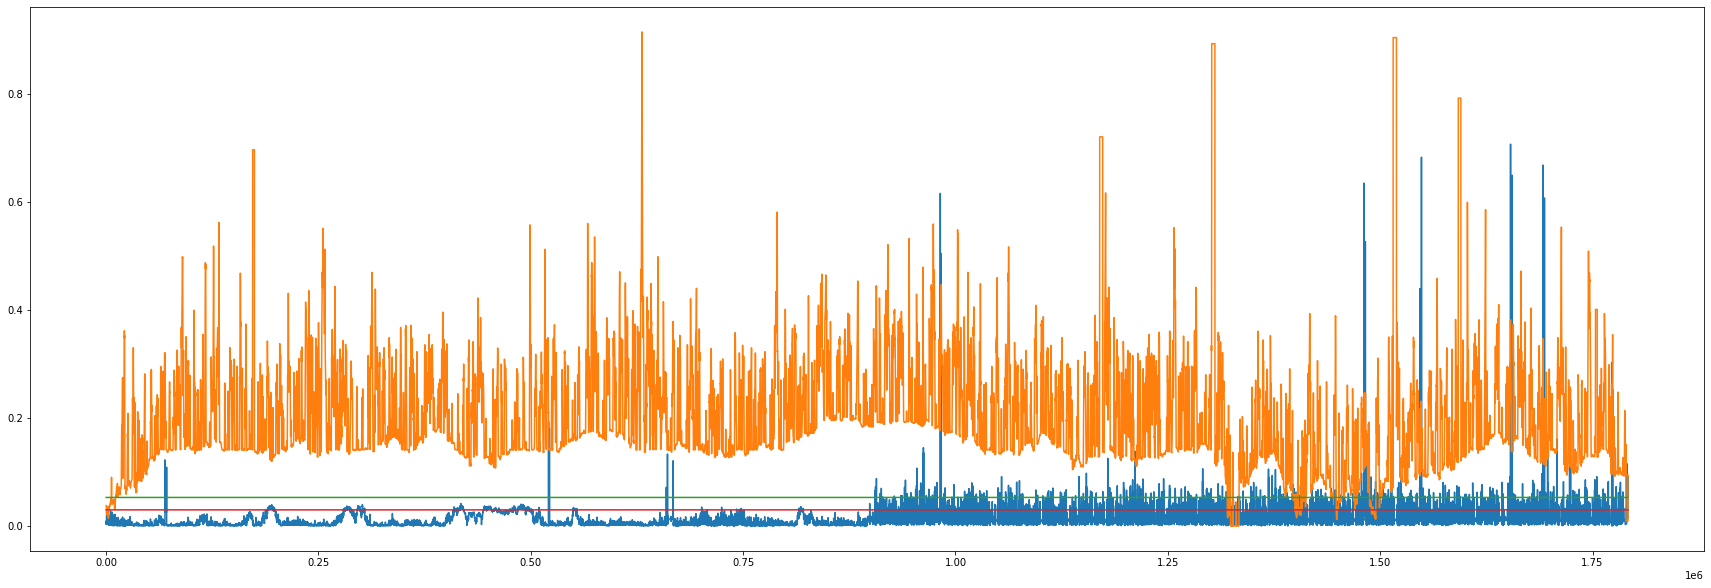

In [36]:
# #plot the threshoold vs the actual loss values
test_score_df_2 = pd.DataFrame(index=df_testID_list[1][TIME_STEP:].index)
test_score_df_2['id_5'] = df_testID_list[1][TIME_STEP:].Signal1_of_ID
test_score_df_2['Label'] = df_testID_list[1][TIME_STEP:].Label
test_score_df_2['loss'] = test_mae_loss_2
test_score_df_2['threshold_1'] = 0.053
test_score_df_2['threshold_2'] = 0.03
test_score_df_2['anomaly_1'] = test_score_df_2.loss > test_score_df_2.threshold_1
test_score_df_2['anomaly_2'] = test_score_df_2.loss > test_score_df_2.threshold_2


plt.figure(figsize=(30,10))
plt.plot(test_score_df_2.index,test_score_df_2.loss, label='loss')
plt.plot(test_score_df_2.index,test_score_df_2.id_5, label='id_5')
plt.plot(test_score_df_2.index,test_score_df_2.threshold_1, label='threshold_1')
plt.plot(test_score_df_2.index,test_score_df_2.threshold_2, label='threshold_2')

#### ROC Curves

In [37]:
def tpr_fpr_cal(anom,notAnom):

    TPs = anom[anom.Label == anom.anomaly_x]
    FPs = anom[anom.Label != anom.anomaly_x]
    FNs= notAnom[notAnom.Label != notAnom.anomaly_x]
    TNs= notAnom[notAnom.Label == notAnom.anomaly_x]

    tpr = TPs.iloc[:,0].shape[0] / (TPs.iloc[:,0].shape[0] + FNs.iloc[:,0].shape[0])
    fpr = FPs.iloc[:,0].shape[0]/ (FPs.iloc[:,0].shape[0] + TNs.iloc[:,0].shape[0])
    

    return tpr,fpr

In [38]:
def roc_from_scratch(test_df, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        test_df['anomaly_x'] = test_df.loss > (i / partitions)
        anomalies = test_df[test_df.loss > (i / partitions)]
        notAnomalies =  test_df[test_df.loss <= (i / partitions)]
        
        # print(notAnomalies)
        tpr, fpr = tpr_fpr_cal(anomalies, notAnomalies)
        if(0.58 > tpr < 0.6):
            print(i / partitions)

        roc = np.append(roc, [fpr, tpr])
        # print(roc)
        
    return roc.reshape(-1, 2)

0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
1.0
ROC_1=
[[1.00000000e

Text(0, 0.5, 'True Positive Rate')

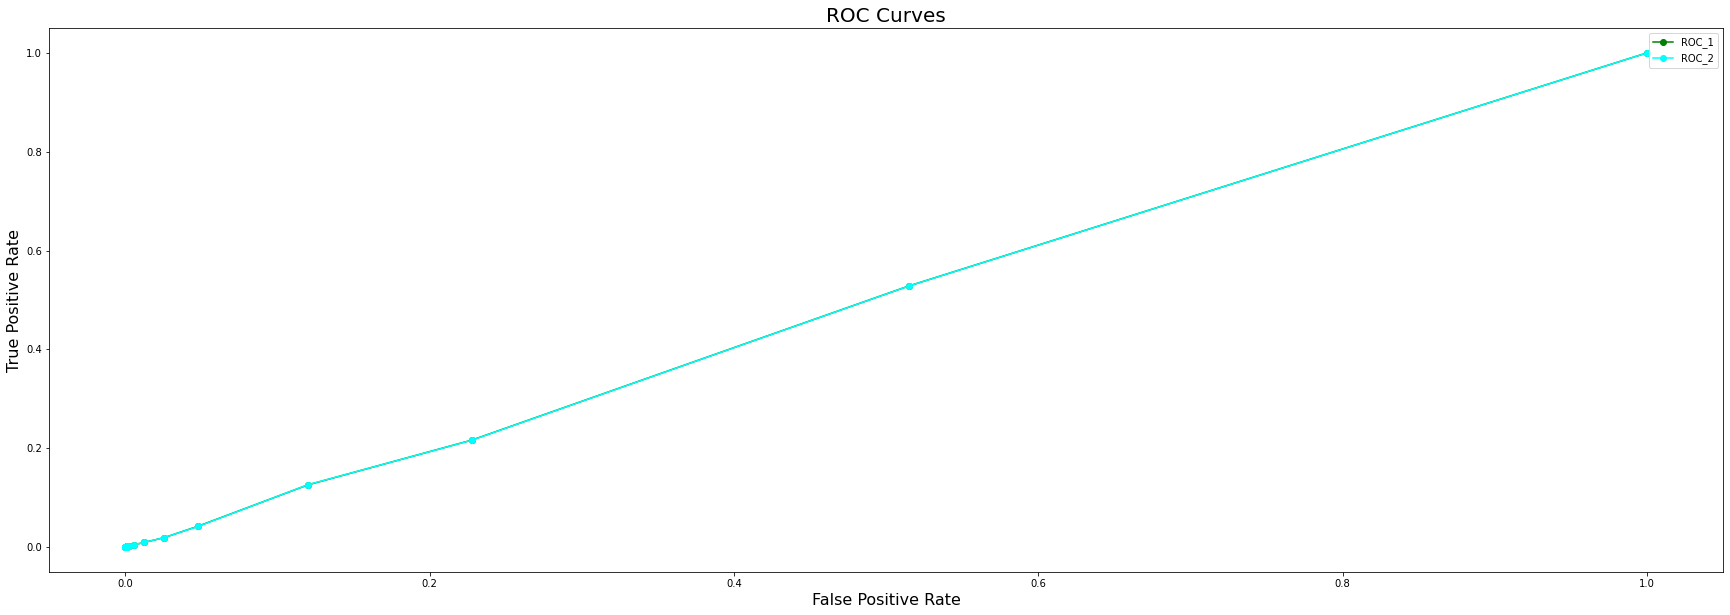

In [39]:
plt.figure(figsize=(30,10))
roc_1 = roc_from_scratch(test_score_df)
roc_2 = roc_from_scratch(test_score_df_2)
print("ROC_1=")
print(roc_1)
print("ROC_2=")
print(roc_2)
plt.plot(roc_1[:,0],roc_1[:,1],color='green', marker='o', label = 'ROC_1')
plt.plot(roc_2[:,0],roc_2[:,1],color='cyan', marker='o', label = 'ROC_2')
plt.legend()
plt.title('ROC Curves',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)

In [46]:
def conf_matrix_cal_1(anom,notAnom,mode):

    TPs = anom[anom.Label == anom.anomaly_1]
    FPs = anom[anom.Label != anom.anomaly_1]
    FNs= notAnom[notAnom.Label != notAnom.anomaly_1]
    TNs= notAnom[notAnom.Label == notAnom.anomaly_1]

    if(mode == 'num'):
        return TPs.iloc[:,0].shape[0],FPs.iloc[:,0].shape[0],FNs.iloc[:,0].shape[0],TNs.iloc[:,0].shape[0]
    else:
        return TPs,FPs,FNs,TNs

In [47]:
def conf_matrix_cal_2(anom,notAnom,mode):

    TPs = anom[anom.Label == anom.anomaly_2]
    FPs = anom[anom.Label != anom.anomaly_2]
    FNs= notAnom[notAnom.Label != notAnom.anomaly_2]
    TNs= notAnom[notAnom.Label == notAnom.anomaly_2]

    if(mode == 'num'):
        return TPs.iloc[:,0].shape[0],FPs.iloc[:,0].shape[0],FNs.iloc[:,0].shape[0],TNs.iloc[:,0].shape[0]
    else:
        return TPs,FPs,FNs,TNs

In [59]:
# Anomalies

anomalies_1_1 = test_score_df[test_score_df.anomaly_1 == True] #threshold 1
anomalies_1_2 = test_score_df[test_score_df.anomaly_2 == True] #threshold 2
anomalies_2_1 = test_score_df_2[test_score_df_2.anomaly_1 == True]
anomalies_2_2 = test_score_df_2[test_score_df_2.anomaly_2 == True]

# Not Anomalies 
notAnomalies_1_1 = test_score_df[test_score_df.anomaly_1 == False]
notAnomalies_1_2 = test_score_df[test_score_df.anomaly_2 == False]
notAnomalies_2_1 = test_score_df_2[test_score_df_2.anomaly_1 == False]
notAnomalies_2_2 = test_score_df_2[test_score_df_2.anomaly_2 == False]

stats = np.empty([4,4],dtype='int')

#for Threshold 1 & 2
# For ID_1 

stats[0] = conf_matrix_cal_1(anomalies_1_1,notAnomalies_1_1,'num')
stats[1] = conf_matrix_cal_2(anomalies_1_2,notAnomalies_1_2,'num')

# For ID_2
stats[2] = conf_matrix_cal_1(anomalies_2_1,notAnomalies_2_1,'num')
stats[3] = conf_matrix_cal_2(anomalies_2_2,notAnomalies_2_2,'num')


stats_df_1_1 = conf_matrix_cal_1(anomalies_1_1,notAnomalies_1_1,'df')
stats_df_1_2 = conf_matrix_cal_2(anomalies_1_2,notAnomalies_1_2,'df')

# For ID_2
stats_df_2_1 = conf_matrix_cal_1(anomalies_2_1,notAnomalies_2_1,'df')
stats_df_2_2 = conf_matrix_cal_2(anomalies_2_2,notAnomalies_2_2,'df')


print(stats)
print(stats_df_2_1[0])

[[   660   4331  41125 203854]
 [  5256  24983  36529 183202]
 [   664   4333  41123 203850]
 [  5263  24954  36524 183229]]
             id_5  Label      loss  threshold_1  threshold_2  anomaly_1  \
522007   0.143237      1  0.065661        0.053         0.03       True   
522016   0.143209      1  0.141440        0.053         0.03       True   
522022   0.143178      1  0.175559        0.053         0.03       True   
522029   0.143137      1  0.180569        0.053         0.03       True   
522037   0.143096      1  0.163639        0.053         0.03       True   
...           ...    ...       ...          ...          ...        ...   
1790489  0.009168      1  0.082211        0.053         0.03       True   
1790496  0.009168      1  0.074634        0.053         0.03       True   
1790504  0.009168      1  0.068441        0.053         0.03       True   
1790509  0.009168      1  0.061898        0.053         0.03       True   
1790519  0.009168      1  0.053914        0.053   

##### Pie charts of TPs vs FPs for All the IDs

[[   660   4331  41125 203854]
 [  5256  24983  36529 183202]
 [   664   4333  41123 203850]
 [  5263  24954  36524 183229]]


Text(0.5, 0.5, 'Threshold 2')

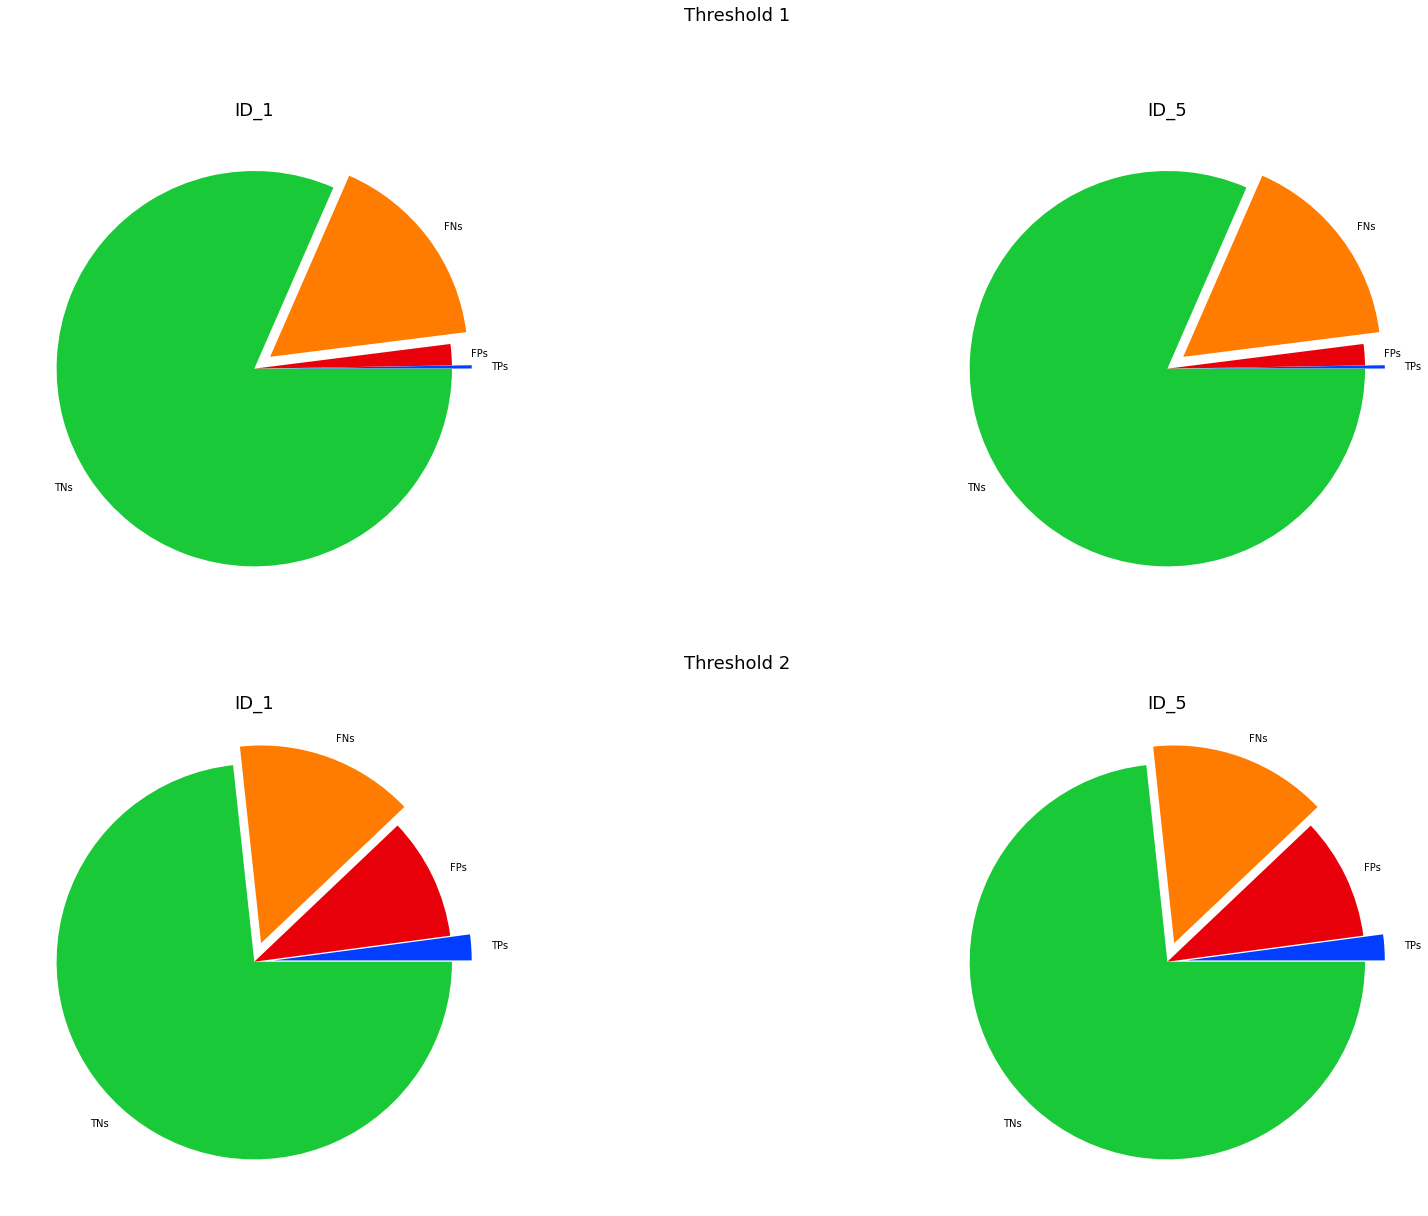

In [72]:
print(stats)
pallete = sns.color_palette('bright')
colors = [pallete[0],pallete[3],pallete[1],pallete[2]]
fig,axs = plt.subplots(2,2,squeeze=False, figsize=(30,20))
fig.set_facecolor('white')
labels = ['TPs', 'FPs', 'FNs', 'TNs']
explode = (0.1, 0, 0.1, 0)

# axs[0].set_title('Threshold 1',fontsize=18)

axs[0,0].set_title('ID_1',fontsize=18)
axs[0,0].pie(
stats[0],
labels = labels,
colors = colors,
explode = explode,
 )

axs[0,1].set_title('ID_5',fontsize=18)

axs[0,1].pie(
stats[2],
labels = labels,
colors = colors,
explode = explode
)
# axs[1].set_title('Threshold 1',fontsize=18)

axs[1,0].set_title('ID_1',fontsize=18)
axs[1,0].pie(
stats[1],
labels = labels,
colors = colors,
explode = explode,
 )

axs[1,1].set_title('ID_5',fontsize=18)

axs[1,1].pie(
stats[3],
labels = labels,
colors = colors,
explode = explode
)
plt.figtext(0.5,0.95,"Threshold 1", fontsize = 18)
plt.figtext(0.5,0.5,"Threshold 2", fontsize = 18)

#### Total anomalies Plotted: Predicted VS Test 

ID_1

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

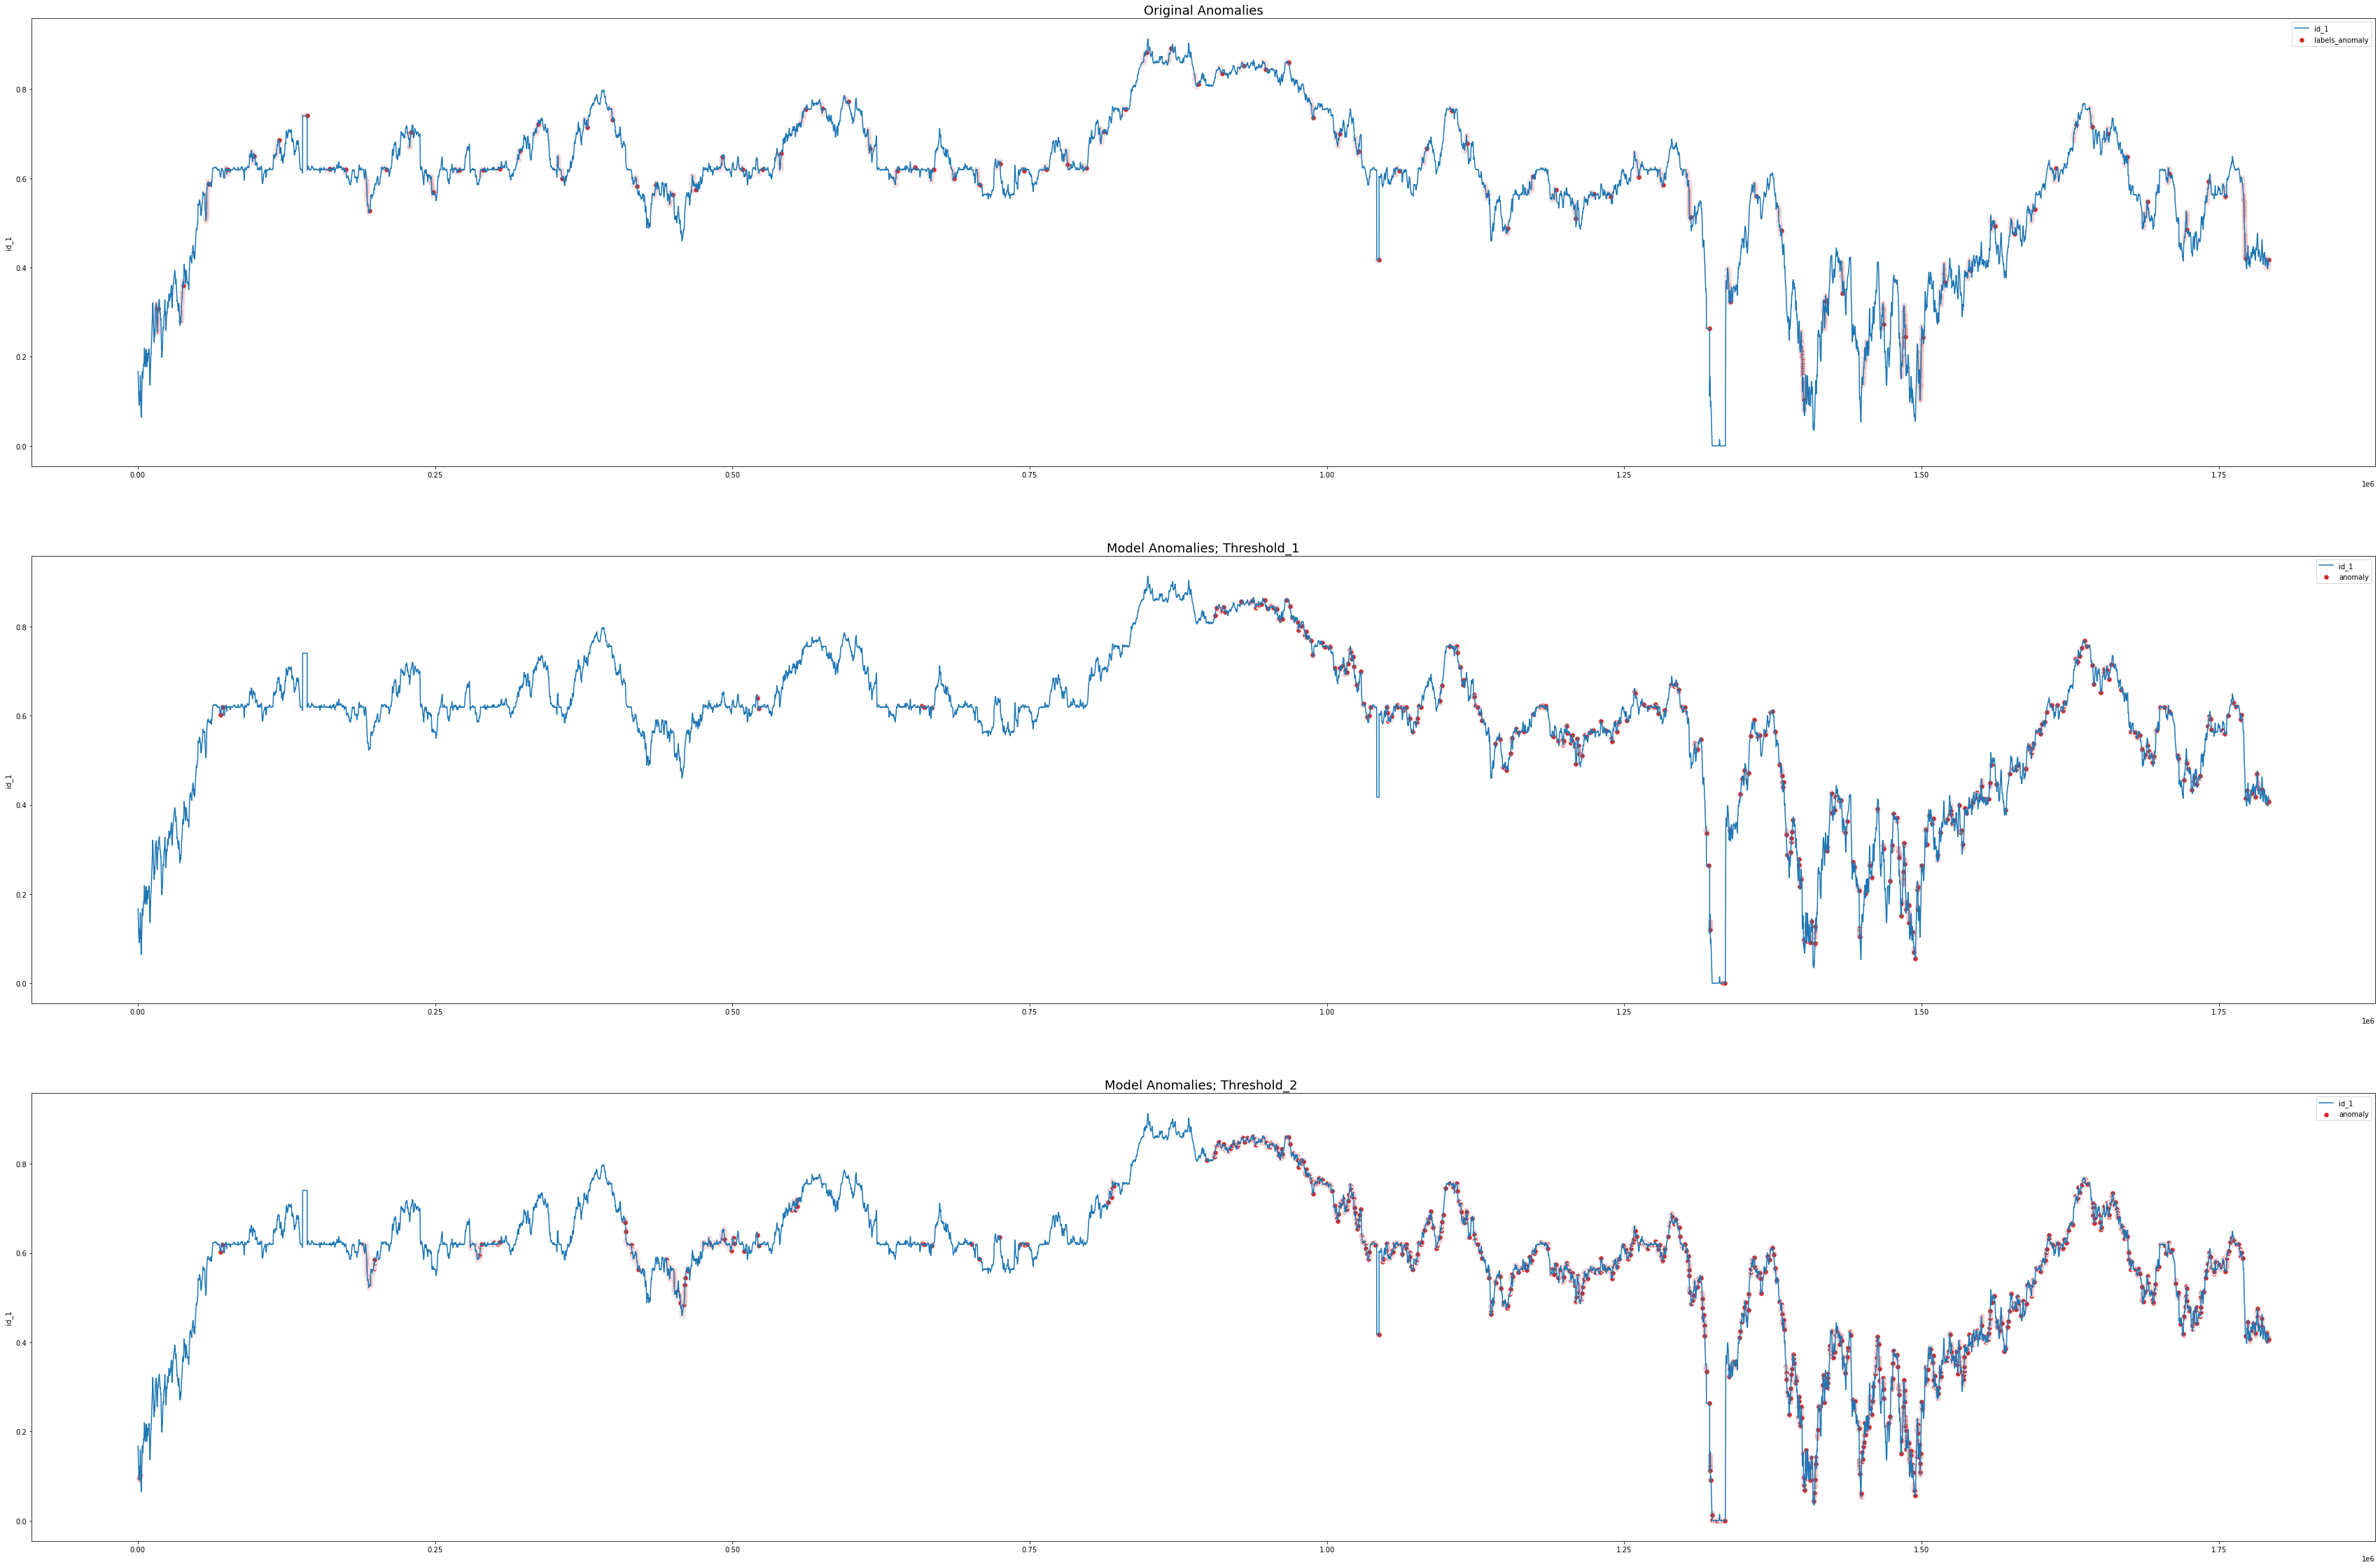

In [ ]:
fig,axs = plt.subplots(3,1,squeeze=False, figsize=(60,40))

axs[0,0].set_title('Original Anomalies',fontsize=18)
axs[0,0].plot(
 test_score_df.index, 
 test_score_df.id_1, 
  label='id_1'
)

test_labels = test_score_df[test_score_df.Label == True]

sns.scatterplot(
  test_labels.index,
  test_labels.id_1,
  color=sns.color_palette()[3],
  s=52,
  label='labels_anomaly',
  ax = axs[0,0]
)

axs[1,0].set_title('Model Anomalies; Threshold_1',fontsize=18)

axs[1,0].plot(
  test_score_df.index, 
  test_score_df.id_1, 
  label='id_1'
  )

sns.scatterplot(
  anomalies_1_1.index,
  anomalies_1_1.id_1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly',
  ax = axs[1,0]
)
axs[2,0].set_title('Model Anomalies; Threshold_2 ',fontsize=18)

axs[2,0].plot(
  test_score_df.index, 
  test_score_df.id_1, 
  label='id_1'
  )

sns.scatterplot(
  anomalies_1_2.index,
  anomalies_1_2.id_1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly',
  ax = axs[2,0]
)

plt.legend();

ID_5

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

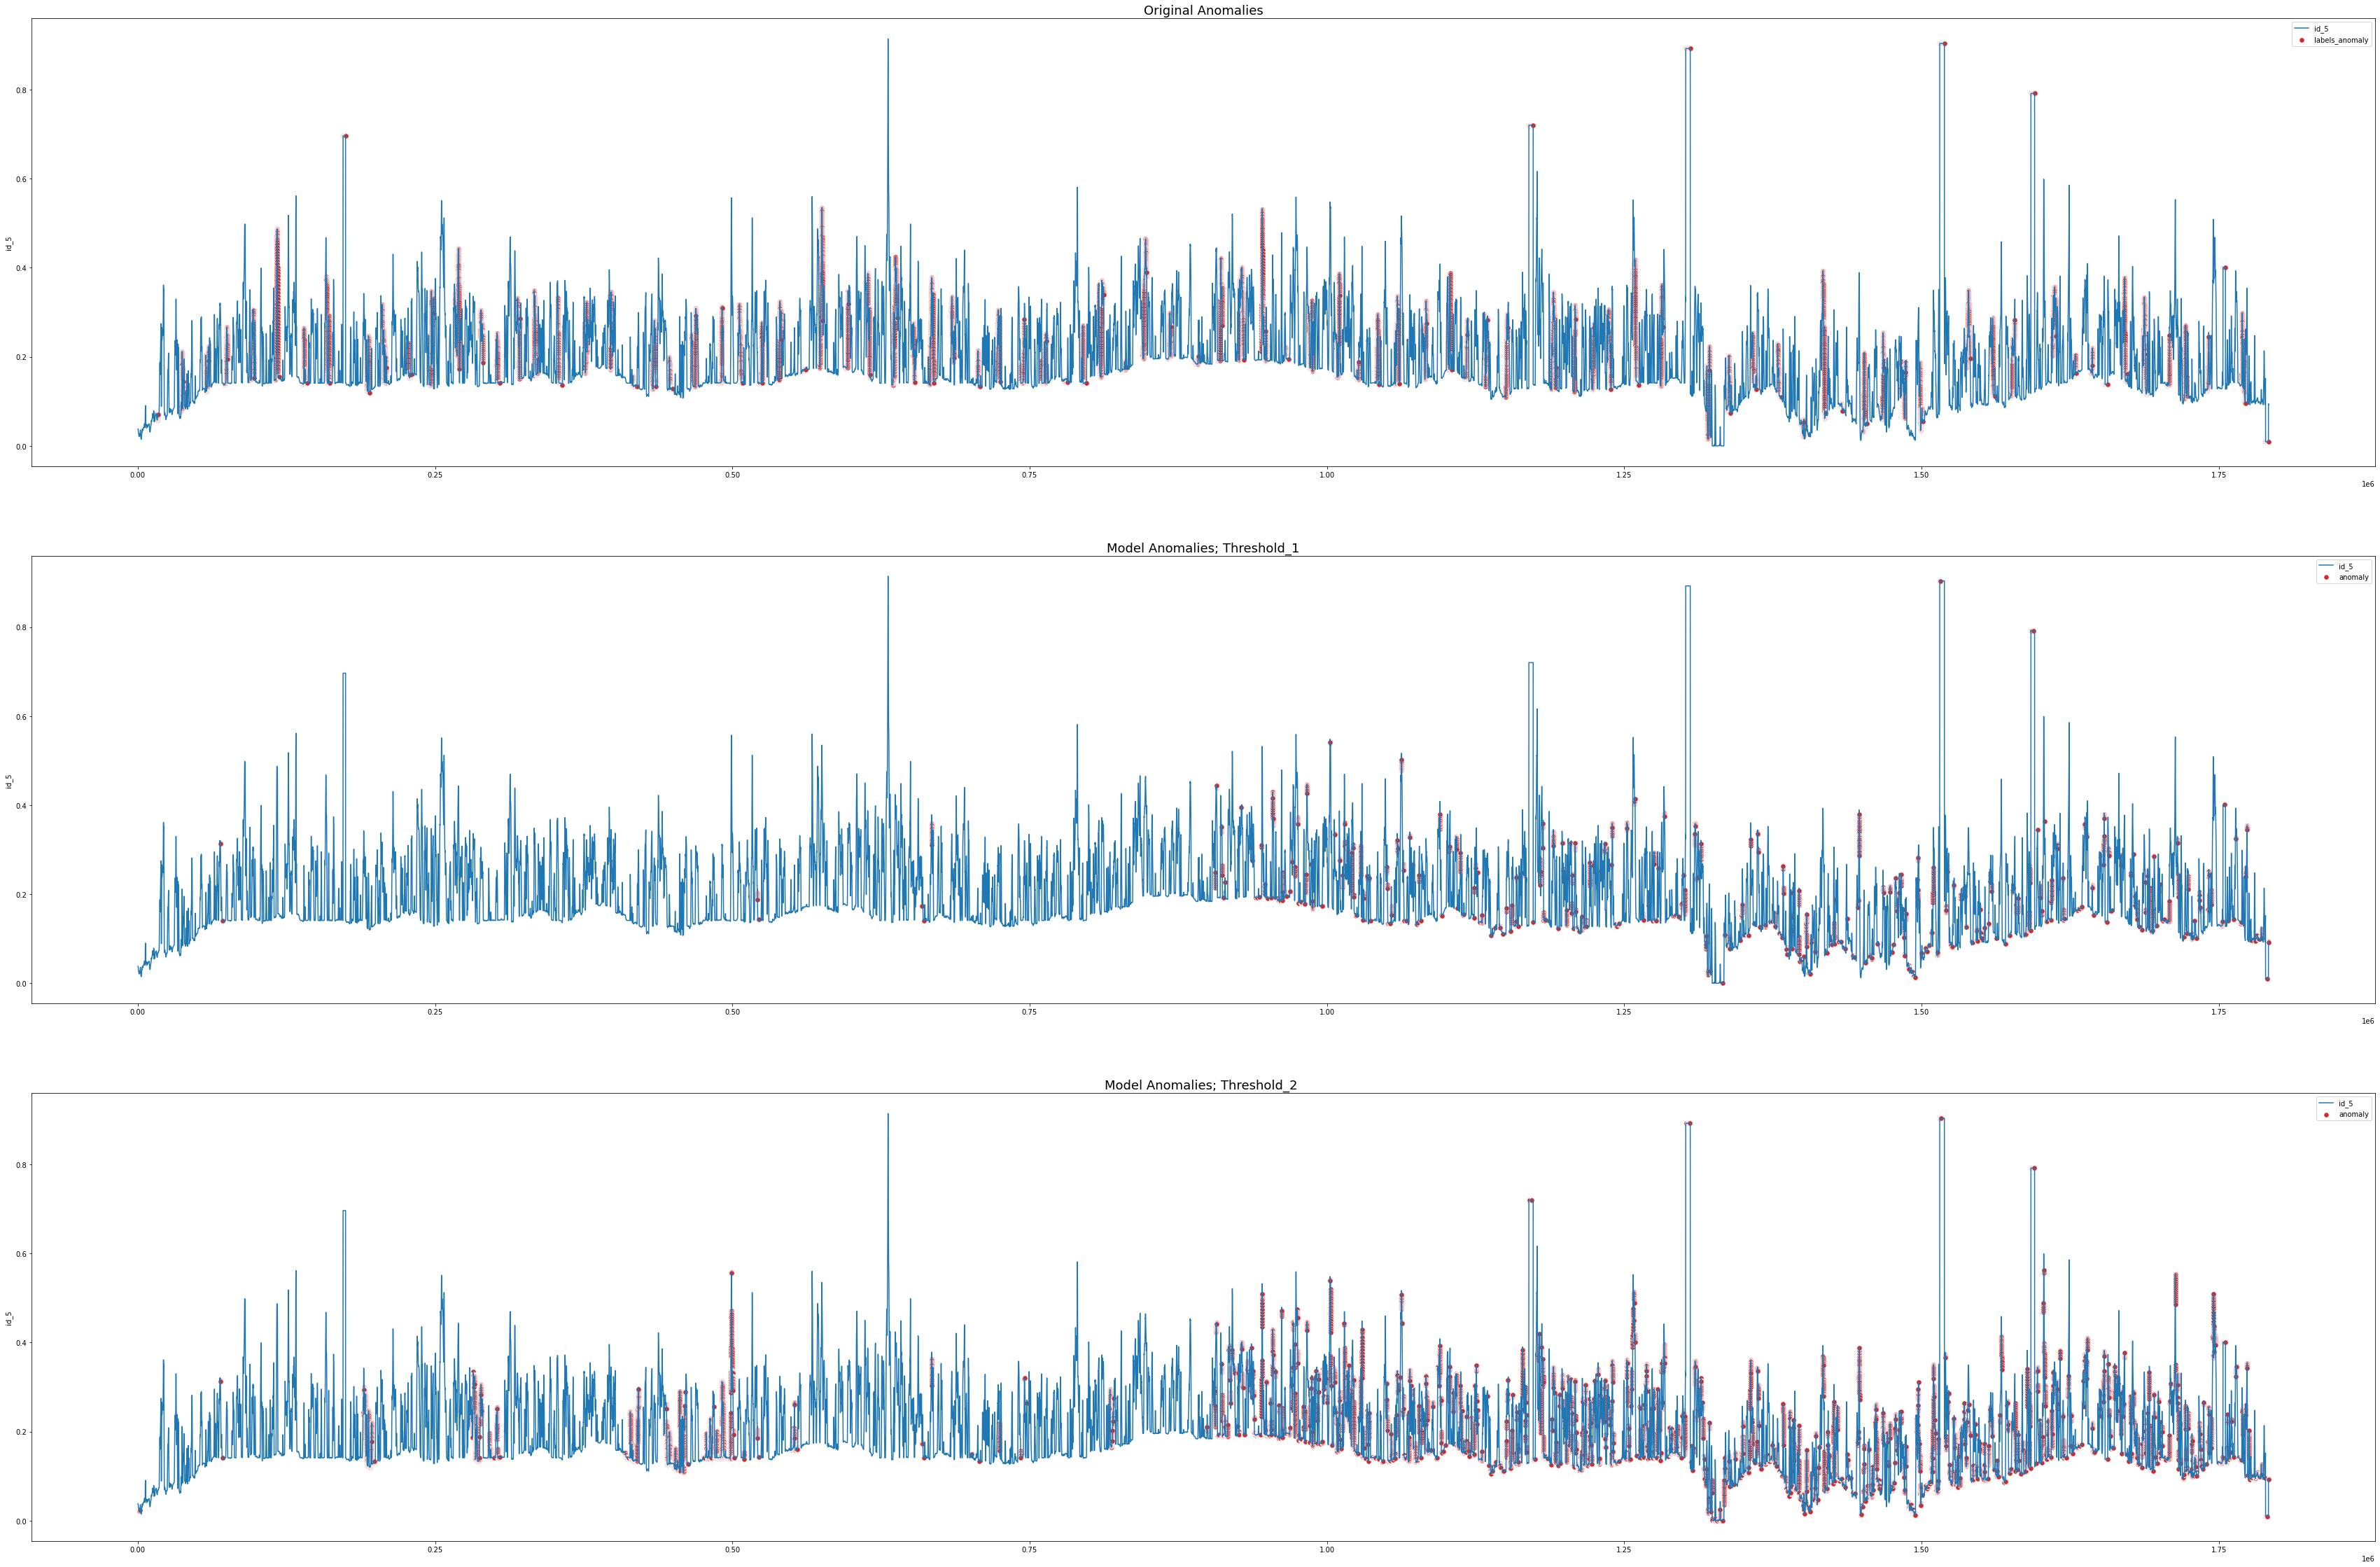

In [64]:
fig,axs = plt.subplots(3,1,squeeze=False, figsize=(60,40))

axs[0,0].set_title('Original Anomalies',fontsize=18)
axs[0,0].plot(
 test_score_df_2.index, 
 test_score_df_2.id_5, 
  label='id_5'
)

test_labels_2 = test_score_df_2[test_score_df_2.Label == True]

sns.scatterplot(
  test_labels_2.index,
  test_labels_2.id_5,
  color=sns.color_palette()[3],
  s=52,
  label='labels_anomaly',
  ax = axs[0,0]
)

axs[1,0].set_title('Model Anomalies; Threshold_1',fontsize=18)

axs[1,0].plot(
  test_score_df_2.index, 
  test_score_df_2.id_5, 
  label='id_5'
  )

sns.scatterplot(
  anomalies_2_1.index,
  anomalies_2_1.id_5,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly',
  ax = axs[1,0]
)
axs[2,0].set_title('Model Anomalies; Threshold_2 ',fontsize=18)

axs[2,0].plot(
  test_score_df_2.index, 
  test_score_df_2.id_5, 
  label='id_5'
  )

sns.scatterplot(
  anomalies_2_2.index,
  anomalies_2_2.id_5,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly',
  ax = axs[2,0]
)

plt.legend();

#### TPs and FPs VS TNs and FNs

ID_1

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

<AxesSubplot:ylabel='id_1'>

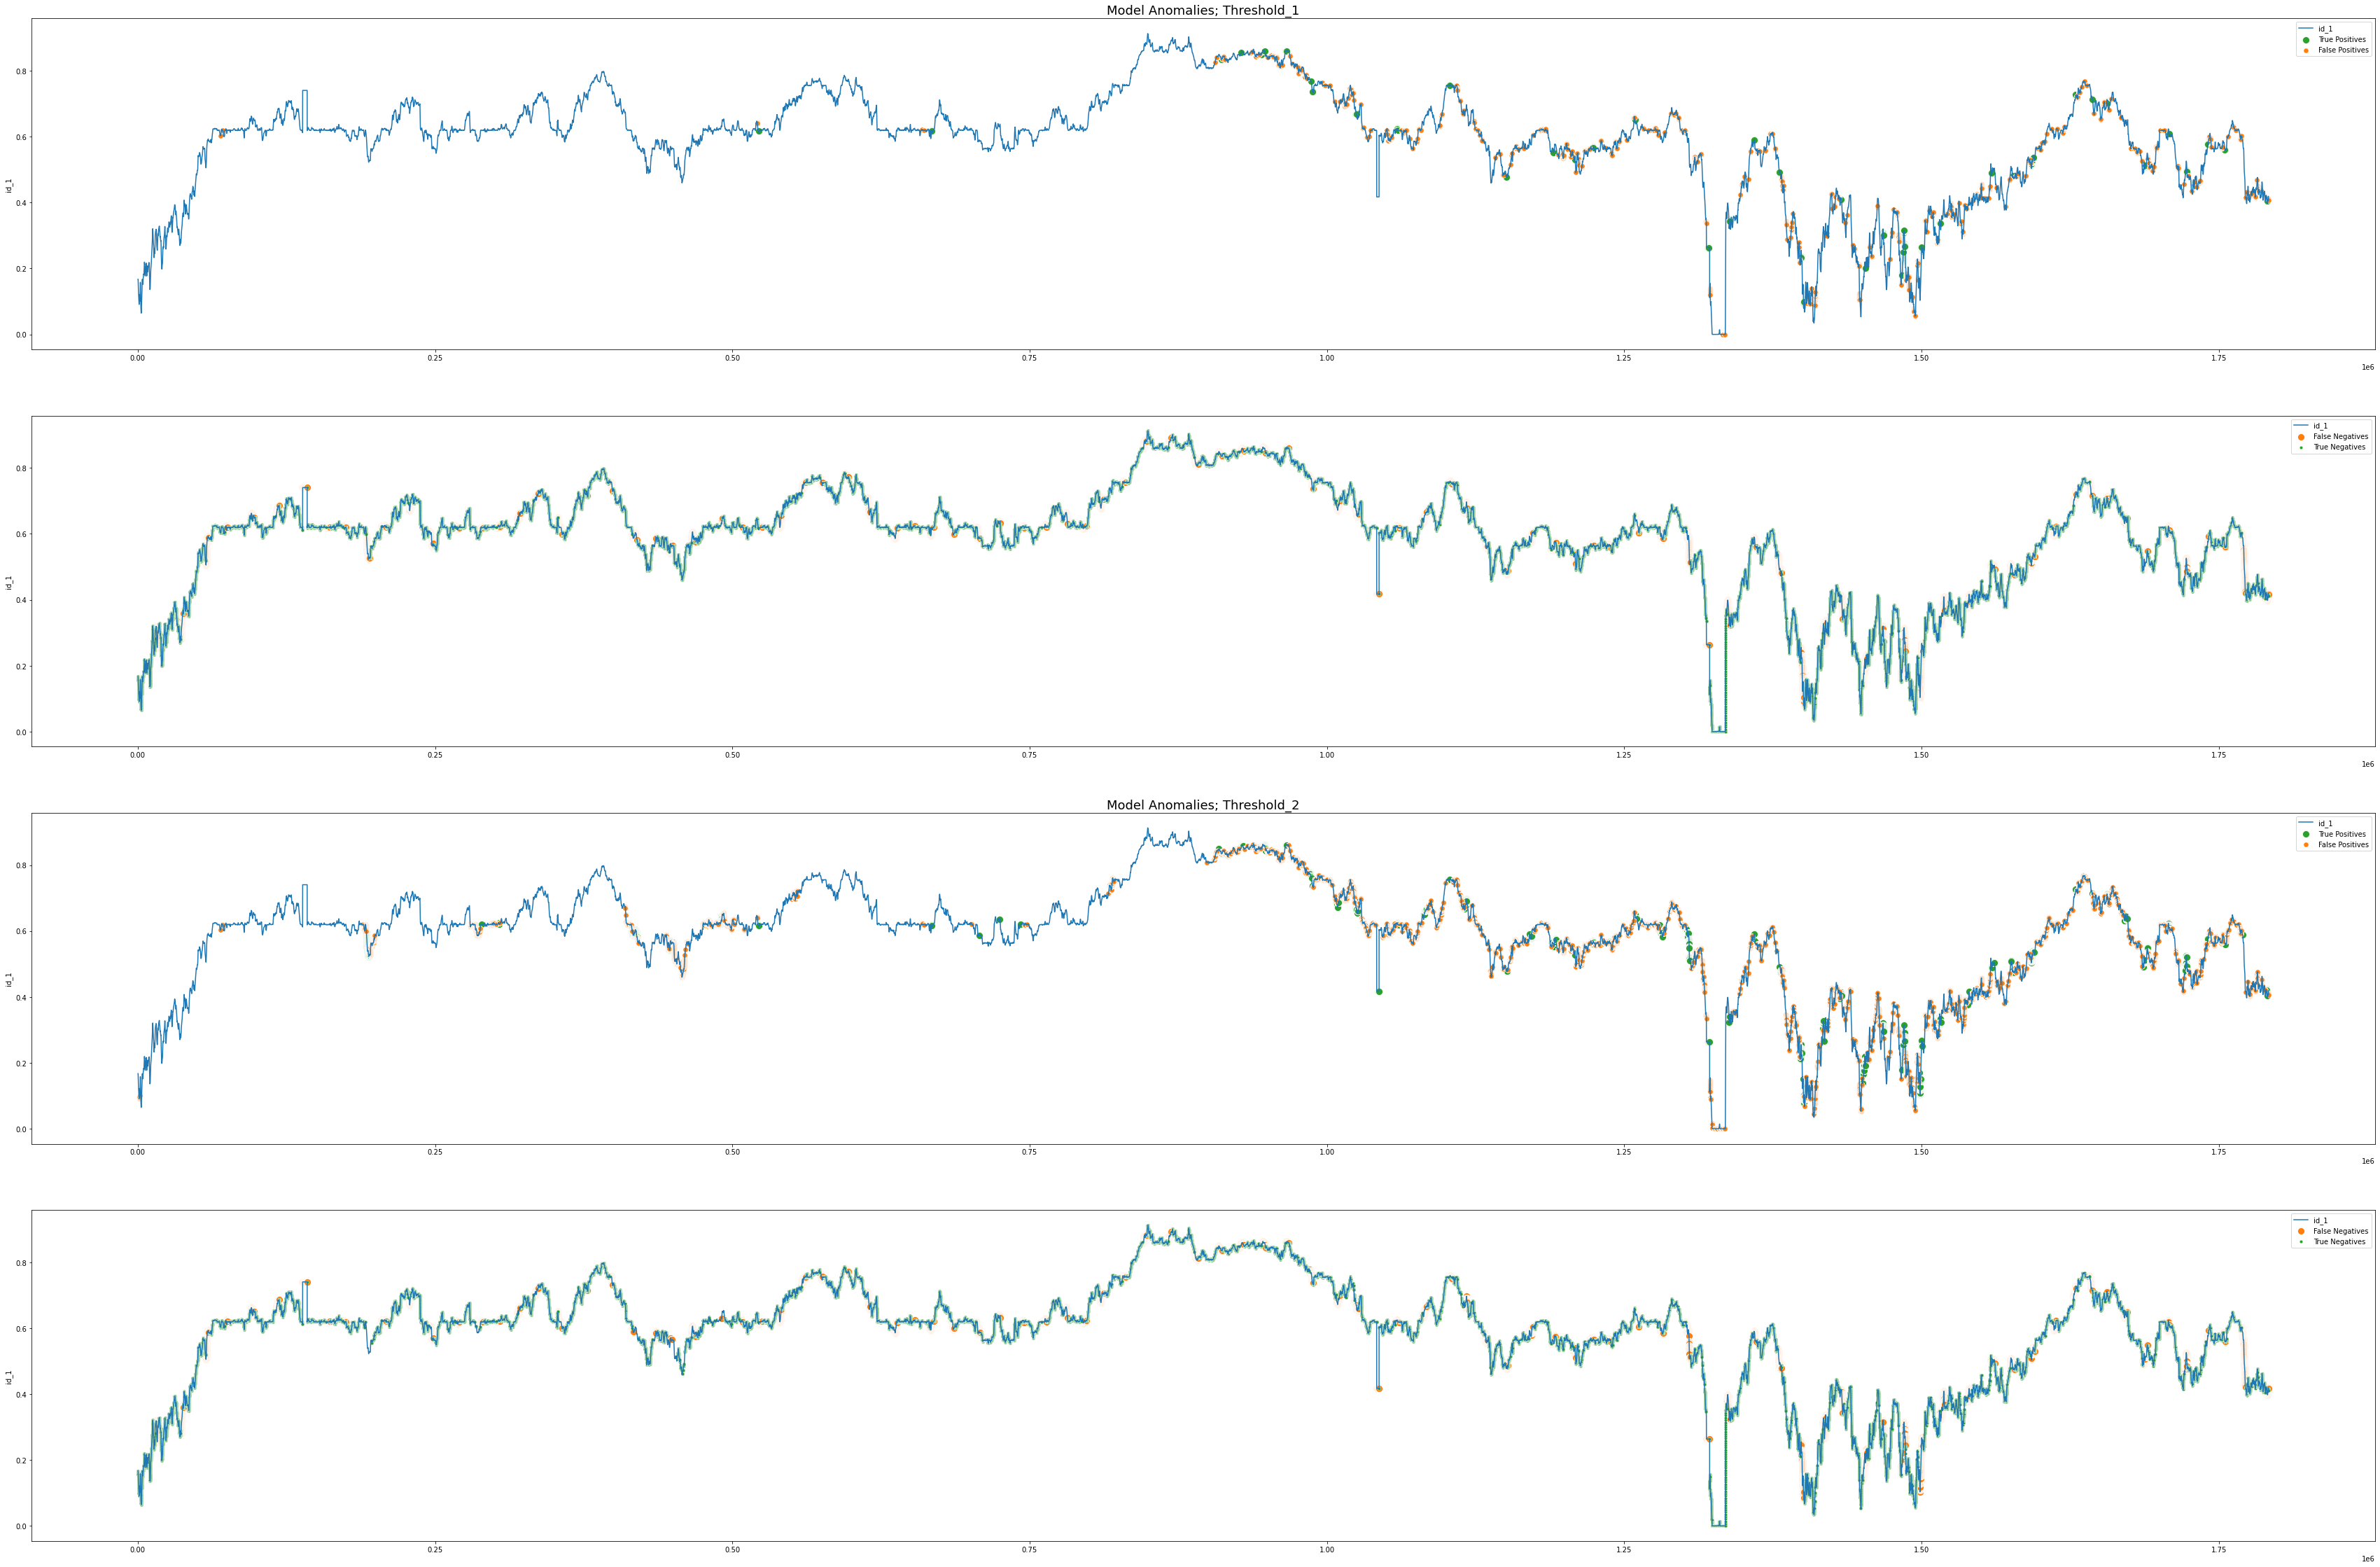

In [62]:
# plt.figure(figsize=(30,10))
fig,axs = plt.subplots(4,1,squeeze=False, figsize=(60,40))

# Threshold 1
axs[0,0].set_title('Model Anomalies; Threshold_1',fontsize=18)

axs[0,0].plot(
test_score_df.index, 
test_score_df.id_1,
label='id_1'
)

sns.scatterplot(
  stats_df_1_1[0].index, 
  stats_df_1_1[0].id_1,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[0,0]
)

sns.scatterplot(
  stats_df_1_1[1].index, 
  stats_df_1_1[1].id_1,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives',
  ax = axs[0,0]
)
plt.legend()
axs[1,0].plot(
test_score_df.index, 
test_score_df.id_1, 
  label='id_1'
)

sns.scatterplot(
  stats_df_1_1[2].index, 
  stats_df_1_1[2].id_1,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[1,0]
)
sns.scatterplot(
  stats_df_1_1[3].index, 
  stats_df_1_1[3].id_1,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[1,0]
)


# Threshold 2
axs[2,0].set_title('Model Anomalies; Threshold_2',fontsize=18)


axs[2,0].plot(
test_score_df.index, 
test_score_df.id_1,
label='id_1'
)

sns.scatterplot(
  stats_df_1_2[0].index, 
  stats_df_1_2[0].id_1,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[2,0]
)

sns.scatterplot(
  stats_df_1_2[1].index, 
  stats_df_1_2[1].id_1,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives',
  ax = axs[2,0]
)
plt.legend()
axs[3,0].plot(
test_score_df.index, 
test_score_df.id_1, 
  label='id_1'
)

sns.scatterplot(
  stats_df_1_2[2].index, 
  stats_df_1_2[2].id_1,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[3,0]
)
sns.scatterplot(
  stats_df_1_2[3].index, 
  stats_df_1_2[3].id_1,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[3,0]
)



ID_2

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

<AxesSubplot:ylabel='id_5'>

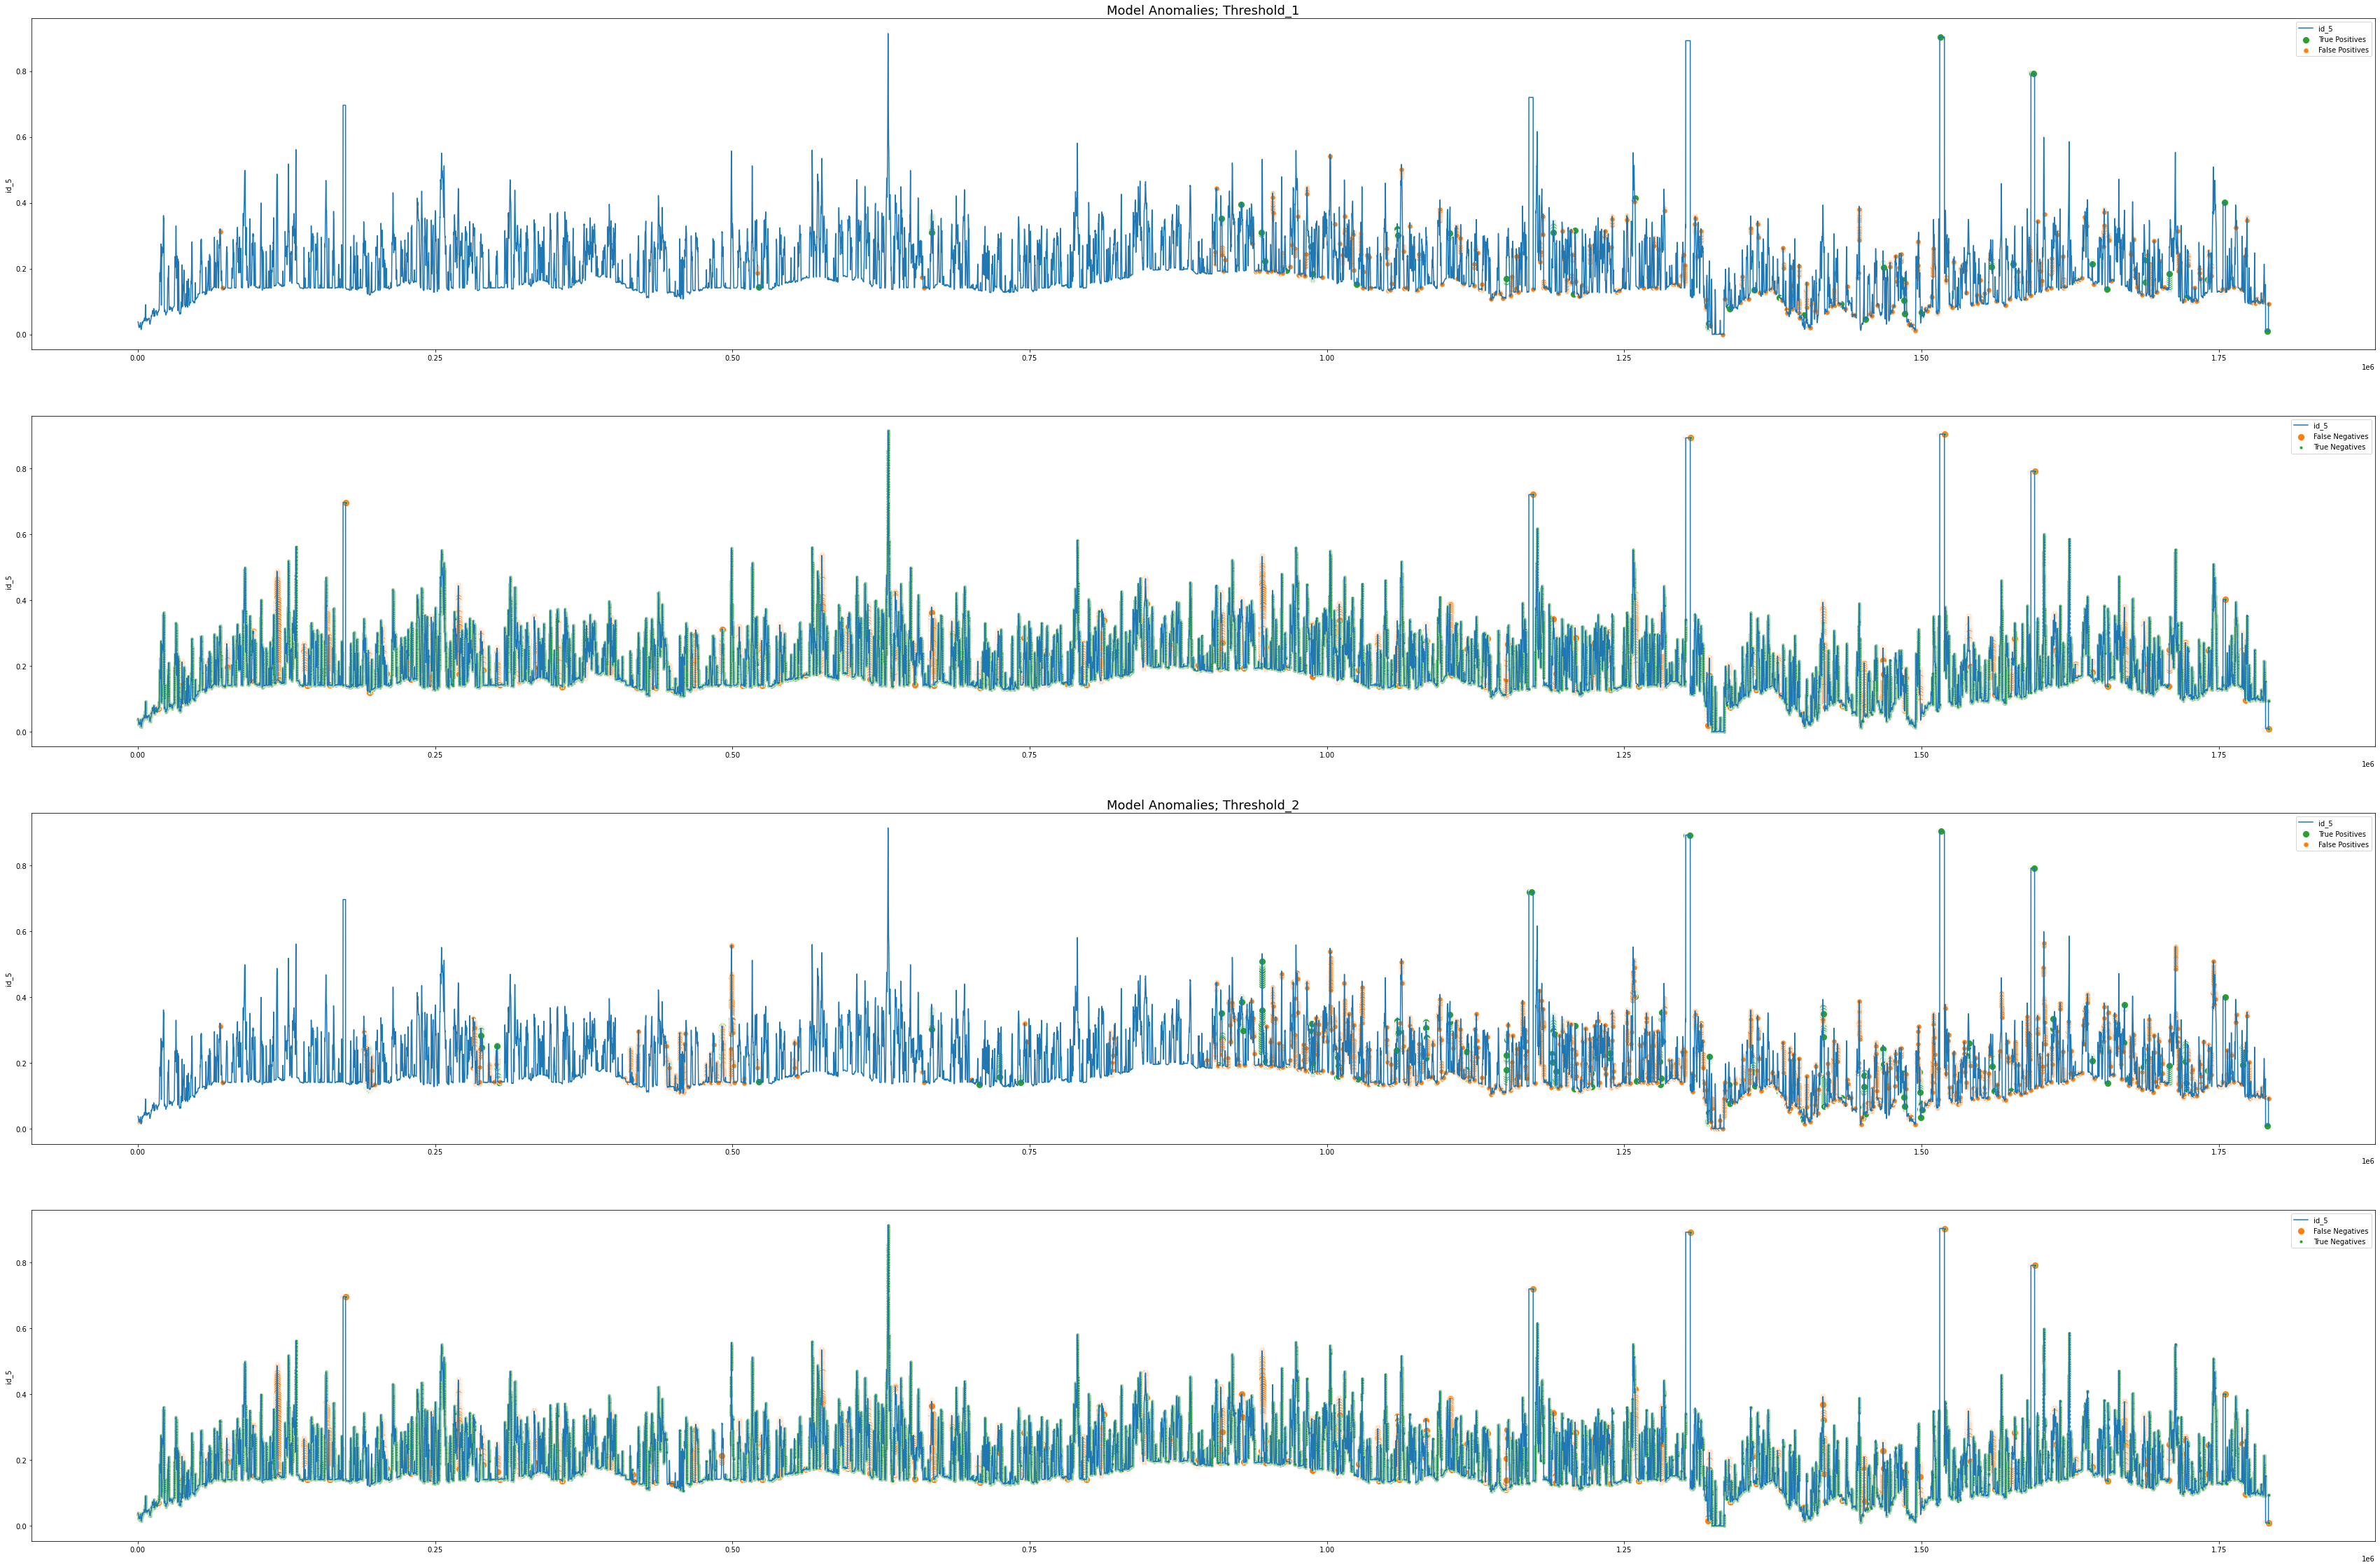

In [63]:
# plt.figure(figsize=(30,10))
fig,axs = plt.subplots(4,1,squeeze=False, figsize=(60,40))

# Threshold 1
axs[0,0].set_title('Model Anomalies; Threshold_1',fontsize=18)

axs[0,0].plot(
test_score_df_2.index, 
test_score_df_2.id_5,
label='id_5'
)

sns.scatterplot(
  stats_df_2_1[0].index, 
  stats_df_2_1[0].id_5,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[0,0]
)

sns.scatterplot(
  stats_df_2_1[1].index, 
  stats_df_2_1[1].id_5,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives',
  ax = axs[0,0]
)
plt.legend()
axs[1,0].plot(
test_score_df_2.index, 
test_score_df_2.id_5, 
  label='id_5'
)

sns.scatterplot(
  stats_df_2_1[2].index, 
  stats_df_2_1[2].id_5,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[1,0]
)
sns.scatterplot(
  stats_df_2_1[3].index, 
  stats_df_2_1[3].id_5,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[1,0]
)


# Threshold 2
axs[2,0].set_title('Model Anomalies; Threshold_2',fontsize=18)


axs[2,0].plot(
test_score_df_2.index, 
test_score_df_2.id_5,
label='id_5'
)

sns.scatterplot(
  stats_df_2_2[0].index, 
  stats_df_2_2[0].id_5,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[2,0]
)

sns.scatterplot(
  stats_df_2_2[1].index, 
  stats_df_2_2[1].id_5,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives',
  ax = axs[2,0]
)
plt.legend()
axs[3,0].plot(
test_score_df_2.index, 
test_score_df_2.id_5, 
  label='id_5'
)

sns.scatterplot(
  stats_df_2_2[2].index, 
  stats_df_2_2[2].id_5,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[3,0]
)
sns.scatterplot(
  stats_df_2_2[3].index, 
  stats_df_2_2[3].id_5,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[3,0]
)

